# Discretización de variables en modelos de clasificación

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print "La matriz de confusión es "
    print confusion_matrix

    print 'Precisión:', accuracy_score(y_true, y_pred)
    print 'Exactitud:', precision_score(y_true, y_pred)
    print 'Exhaustividad:', recall_score(y_true, y_pred)
    print 'F1:', f1_score(y_true, y_pred)

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print 'AUC:', auc(false_positive_rate, recall)

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

## Importación de los datos

In [3]:
import pandas as pd

credit_approval = pd.read_csv('crx_data.txt', sep = ',')
credit_approval.head(n = 5)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [4]:
# Eliminación de los nulos
mask            = credit_approval.applymap(lambda x: x in ['?'])
credit_not_null = credit_approval[-mask.any(axis=1)]

# Validación de los valores numericos
credit_not_null.loc[:, 'A2'] = credit_not_null['A2'].map(lambda x: float(x))

# Separación de las variables
var_categoricas = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']
var_numericas   = ['A2', 'A3', 'A8', 'A15']
var_target      = credit_not_null['A16'] == '+'

/Users/daniel/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Análisis de las variables discretas

Se pueden analizar las variables mediante la utilización de tablas de frecuencia para comprobar la forma en la que los valore se reparte.

In [5]:
for var in var_categoricas:
    print "Tabla de frecuencias para:", var
    print pd.crosstab(credit_not_null['A16'], credit_not_null[var])
    print

Tabla de frecuencias para: A1
A1     a    b
A16          
+     95  201
-    108  249

Tabla de frecuencias para: A4
A4   l    u    y
A16             
+    2  249   45
-    0  250  107

Tabla de frecuencias para: A5
A5     g  gg    p
A16              
+    249   2   45
-    250   0  107

Tabla de frecuencias para: A6
A6   aa   c  cc   d   e  ff   i  j   k   m   q  r   w   x
A16                                                      
+    19  60  29   7  14   7  14  3  13  16  49  2  33  30
-    33  73  11  19  10  43  41  7  35  22  26  1  30   6

Tabla de frecuencias para: A7
A7   bb  dd  ff   h  j  n  o    v  z
A16                                 
+    24   2   8  87  3  2  1  163  6
-    29   4  46  50  5  2  1  218  2

Tabla de frecuencias para: A9
A9     f    t
A16          
+     18  278
-    286   71

Tabla de frecuencias para: A10
A10    f    t
A16          
+     93  203
-    273   84

Tabla de frecuencias para: A11
A11   0   1   2   3   4   5   6   7   8   9  ...  13  14  15  1

En algunas de las variables existe niveles que pocos registros significativos. Estas niveles se han de agrupar con otros en niveles que agrupen más registros de forma que puedan ser significativos. Se puede utilizar el peso de la evidencia (WoE, Weight of Evidence) para compara la capacidad predictiva de cada uno de los niveles de una variable:
$$
    WoE_i = \ln \left| \frac{R_i(T)}{R_i(F)} \right|.
$$
El valor del WoE se puede situar entre menos infinito, todos los registros del nivel son negativos, e infinito, todos los registros del nivel son positivos.

Si recordamos la definición de IV podemos ver que este es un promedio ponderado de los WoE de cada uno de los segmetnos:
$$
    IV = \sum_{i = 1}^{N} (R_i(T) - R_i(F)) \ln \left| \frac{R_i(T)}{R_i(F)} \right| = \sum_{i = 1}^{N} (R_i(T) - R_i(F)) WoE_i
$$

### Variable `A13`: Un nivel con pocos valores

En la variable `A13` se puede observar que el nivel `p` En la variable `A13` se puede observar que el nivel `p` tiene solamente 2 registro, uno que es positivo y otro que es negativo. Esta nivel se puede agrupar en otro utilizando el WoE:  tiene solamente 2 registro, uno que es positivo y otro que es negativo. Esta nivel se puede agrupar en otro utilizando el WoE: 

In [6]:
def get_WoE(data, var, target):
    crosstab = pd.crosstab(data[target], data[var])
    
    print "Obteniendo el Woe para la variable", var, ":"
    
    for col in crosstab.columns:
        if crosstab[col][1] == 0:
            print "  El WoE para", col, "[", sum(crosstab[col]), "] es infinito"
        else:
            print "  El WoE para", col, "[", sum(crosstab[col]), "] es", np.log(float(crosstab[col][0]) / float(crosstab[col][1]))
            
get_WoE(credit_not_null, 'A13', 'A16') 

Obteniendo el Woe para la variable A13 :
  El WoE para g [ 598 ] es -0.127261779611
  El WoE para p [ 2 ] es 0.0
  El WoE para s [ 53 ] es -0.929535958624


En los resultados se puede observar que el nivel `p`  solamente tiene 2 niveles y un WoE de cero, por lo que no tiene ningún nivel discriminatorio. Este nivel se puede asociar con el `g`, el que muestra un valor de WoE más parecido, en un nuevo nivel.

In [7]:
credit_not_null.loc[:, 'B13'] = credit_not_null['A13'].map(lambda x: 'ns' if x == 's' else 'gp')
get_WoE(credit_not_null, 'B13', 'A16') 

Obteniendo el Woe para la variable B13 :
  El WoE para gp [ 600 ] es -0.126836433451
  El WoE para ns [ 53 ] es -0.929535958624


/Users/daniel/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


### Variable A4: Un nivel con pocos valores

En la variable A4 pasa lo mismo que en la A13 pero con una diferencia, el nivel en el que solamente existen dos registros son ambos positivos

In [8]:
get_WoE(credit_not_null, 'A4', 'A16') 

Obteniendo el Woe para la variable A4 :
  El WoE para l [ 2 ] es infinito
  El WoE para u [ 499 ] es -0.00400802139754
  El WoE para y [ 152 ] es -0.866166344692


En este caso se puede asociar los niveles `l` y `u` en uno nuevo.

In [9]:
credit_not_null.loc[:, 'B4'] = credit_not_null['A4'].map(lambda x: 'ny' if x == 'y' else 'lu')
get_WoE(credit_not_null, 'B4', 'A16') 

Obteniendo el Woe para la variable B4 :
  El WoE para lu [ 501 ] es 0.00399202126954
  El WoE para ny [ 152 ] es -0.866166344692


### Variable A11: Demasiados niveles
En el caso de la variable `A11`  se puede observar que existen demasiados niveles, mucho de los cuales tiene menos de cinco valores. Para esta variable se puede observar que los valores del WoE son

In [10]:
print "La cantidad de niveles en la variable A11 es:", len(unique(credit_not_null['A11']))
get_WoE(credit_not_null, 'A11', 'A16') 

La cantidad de niveles en la variable A11 es: 23
Obteniendo el Woe para la variable A11 :
  El WoE para 0 [ 366 ] es -1.07687230203
  El WoE para 1 [ 69 ] es -0.0870113769896
  El WoE para 2 [ 42 ] es -0.287682072452
  El WoE para 3 [ 27 ] es 0.864997437487
  El WoE para 4 [ 15 ] es 1.38629436112
  El WoE para 5 [ 17 ] es 2.01490302054
  El WoE para 6 [ 22 ] es 1.8458266905
  El WoE para 7 [ 16 ] es 2.7080502011
  El WoE para 8 [ 10 ] es infinito
  El WoE para 9 [ 10 ] es infinito
  El WoE para 10 [ 8 ] es 0.0
  El WoE para 11 [ 19 ] es 2.8903717579
  El WoE para 12 [ 8 ] es 1.94591014906
  El WoE para 13 [ 1 ] es infinito
  El WoE para 14 [ 8 ] es infinito
  El WoE para 15 [ 4 ] es infinito
  El WoE para 16 [ 3 ] es infinito
  El WoE para 17 [ 2 ] es infinito
  El WoE para 19 [ 1 ] es infinito
  El WoE para 20 [ 2 ] es 0.0
  El WoE para 23 [ 1 ] es infinito
  El WoE para 40 [ 1 ] es infinito
  El WoE para 67 [ 1 ] es infinito


En este caso la agrupación es más compleja que en los casos anteriores

In [11]:
credit_not_null.loc[:, 'B11'] = None

for row in credit_not_null.index:
    if credit_not_null.loc[row, 'A11'] == 0:
        credit_not_null.loc[row, 'B11'] = 'n1'
    elif credit_not_null.loc[row, 'A11'] in (1, 2, 10, 20):
        credit_not_null.loc[row, 'B11'] = 'n0'
    elif credit_not_null.loc[row, 'A11'] == 3:
        credit_not_null.loc[row, 'B11'] = 'p0'
    elif credit_not_null.loc[row, 'A11'] in (4, 5, 6, 7, 11, 12):
        credit_not_null.loc[row, 'B11'] = 'p1'
    else:
        credit_not_null.loc[row, 'B11'] = 'p2'
        
get_WoE(credit_not_null, 'B11', 'A16') 

Obteniendo el Woe para la variable B11 :
  El WoE para n0 [ 121 ] es -0.14903557916
  El WoE para n1 [ 366 ] es -1.07687230203
  El WoE para p0 [ 27 ] es 0.864997437487
  El WoE para p1 [ 97 ] es 2.05645202346
  El WoE para p2 [ 42 ] es infinito


Los 23 niveles originales se pueden agrupar en 5 con mayor cantidad de registros que los originales. 

## Análisis de las variables continuas

Las variables continuas se pueden analizar mediante la utilización de histogramas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108e47190>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109077a90>]], dtype=object)

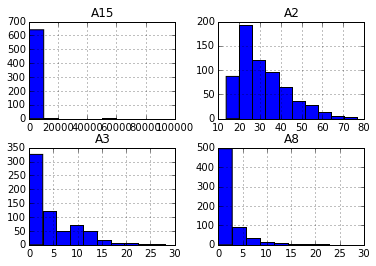

In [12]:
credit_not_null[var_numericas].hist()

Se puede analizar si el histograma de positivos en igual al histograma de negativos. En de los positivos se tiene:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1093ad9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109704e90>]], dtype=object)

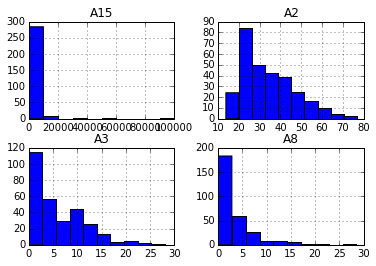

In [13]:
credit_not_null[var_numericas][var_target].hist()

y en el caso de los negativos:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109a88f90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109d4c7d0>]], dtype=object)

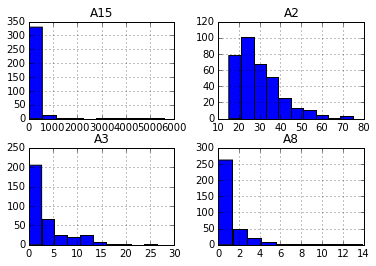

In [14]:
credit_not_null[var_numericas][var_target == False].hist()

Al comparar las gráficas se puede observar que en la variable A3 hay tres zonas, en la primera predominan los negativos, en el medio dominan los positivos y al final aumentan aún más el ratio de positivos. A partir de esto se puede crear una variable categórica a partir desde los datos numericos

In [15]:
credit_not_null.loc[:, 'B3'] = credit_not_null['A3'].map(lambda x: 'n0' if x < 5 else 'n1' if x < 15 else 'n2')
get_WoE(credit_not_null, 'B3', 'A16') 

Obteniendo el Woe para la variable B3 :
  El WoE para n0 [ 417 ] es -0.535201429764
  El WoE para n1 [ 207 ] es 0.341443249343
  El WoE para n2 [ 29 ] es 0.965080896044


La variable A8 se pueden analizar de forma análoga.

In [16]:
credit_not_null.loc[:, 'B8'] = credit_not_null['A8'].map(lambda x: 'n0' if x < 1 else 'n1' if x < 2 else 'n2')
get_WoE(credit_not_null, 'B8', 'A16') 

Obteniendo el Woe para la variable B8 :
  El WoE para n0 [ 308 ] es -1.01381575201
  El WoE para n1 [ 123 ] es 0.0487901641694
  El WoE para n2 [ 222 ] es 0.754599959774


## Creación de un modelo con variables discretizadas

La matriz de confusión es 
[[314 115]
 [ 43 181]]
Precisión: 0.758039816233
Exactitud: 0.611486486486
Exhaustividad: 0.808035714286
F1: 0.696153846154
AUC: 0.76998522311


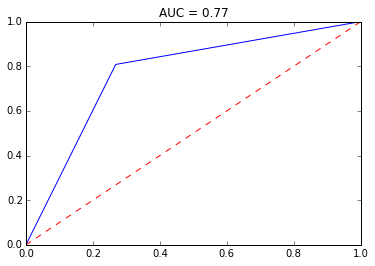

In [17]:
from sklearn.linear_model.logistic import LogisticRegression

data_model = concatenate((pd.get_dummies(credit_not_null['B3']),
                          pd.get_dummies(credit_not_null['B4']),
                          pd.get_dummies(credit_not_null['B8']),
                          pd.get_dummies(credit_not_null['B11'])), axis = 1)

classifier = LogisticRegression().fit(data_model, var_target)
y_pred     = classifier.predict(data_model)

metricas_modelos(y_pred, var_target)

In [18]:
classifier.coef_

array([[-0.28230119,  0.1903189 ,  0.51444263,  0.50116194, -0.0787016 ,
        -0.59307598,  0.24022374,  0.77531257, -0.90113975, -1.66230138,
         0.04793221,  1.03649952,  1.90146974]])